In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Normalizer
from IPython.display import display
from scipy.sparse.linalg import svds

### 0.1 - Load and Prepare Data

In [41]:
# Load df_books and genres
wd = os.getcwd()
df_books = pd.read_csv(wd + "/data/goodreads_books.csv")
df_inferred_genres = pd.read_csv(wd + "/data/inferred_genres.csv")
genre_descriptors = pd.read_csv(wd + "/data/inferred_genre_top_words.csv")

# Join genres to books
df_books = pd.merge(df_books, df_inferred_genres.drop(columns="title"), how="left", on="book_id")

In [42]:
# Load sparse_reviews from file
df_reviews = sparse.load_npz(wd + "/data/user_reviews.npz")

# Load user (rows) and book (cols) indices
user_index = pd.read_csv(wd + "/data/user_index_for_sparse_matrix.csv").rename(columns={"0":"user_id"})
book_index = pd.read_csv(wd + "/data/book_index_for_sparse_matrix.csv").rename(columns={"0":"book_id"})

In [43]:
# Load my goodreads history
my_books = pd.read_csv(wd + "/data/goodreads_library_export.csv")

# Filter to books I've rated
my_books = my_books[["Book Id", "My Rating", "Title"]]\
    .rename(columns={"Book Id":"book_id", "My Rating":"rating", "Title":"title"}).query("rating > 0")
print(f"Target reader ratings: {my_books.shape[0]}")

# Reformat to fit sparse matrix
my_books_1 = pd.merge(
                my_books, df_books[["book_id", "title"]], 
                how="left", on="book_id", suffixes=["_mb","_dfb"]
            )
my_books_id_match = my_books_1[~my_books_1["title_dfb"].isna()]
print(f"Matching on book_id: {my_books_id_match.shape[0]}")

my_books_2 = pd.merge(
    my_books_1[my_books_1["title_dfb"].isna()], df_books[["book_id", "title"]], 
    how="left", left_on="title_mb", right_on="title", suffixes=["_mb","_dfb"]
    )
my_books_match_on_title = my_books_2[~my_books_2["title"].isna()]
print(f"Matching on title: {my_books_match_on_title.shape[0]}")

my_books_id_match = my_books_id_match[["book_id", "rating", "title_dfb"]]\
                        .rename(columns={"title_dfb":"title"})
my_books_match_on_title = my_books_match_on_title[["book_id_dfb", "rating", "title"]]\
                        .rename(columns={"book_id_dfb":"book_id"})

my_books_3 = pd.concat([my_books_id_match, my_books_match_on_title])
my_books_3 = my_books_3.drop_duplicates(subset="book_id")
print(f"Total matches: {my_books_3.shape[0]}, {(my_books_3.shape[0] / my_books.shape[0]):.2%} of total")

my_books_4 = pd.merge(book_index, my_books_3, how="left", on="book_id").fillna(0.)
my_books = np.array(my_books_4["rating"]).reshape(1,-1)

# Add to sparse matrix
df_reviews = sparse.vstack([df_reviews, my_books])

df_reviews = sparse.csr_matrix(df_reviews
                               )
# # Normalize reviews within users
# norm = Normalizer()
# df_reviews = norm.fit_transform(df_reviews) 

Target reader ratings: 166
Matching on book_id: 30
Matching on title: 65
Total matches: 95, 57.23% of total


In [44]:
# Set target reader to make recommendations for
target = df_reviews.shape[0] - 1

#### 0.2 - Functions to Process Recommendations

In [45]:
# Function to use KNN to find similar users
def find_neighbors(n_neighbors, target_user, ratings_df, ind_books, books):

    # Instantiate KNN
    n_neighbors = n_neighbors

    nn_model = NearestNeighbors(
        metric="cosine",
        algorithm="auto",
        n_neighbors=n_neighbors,
        n_jobs=-1
    )

    # Fit to sparse matrix
    nn_model.fit(ratings_df)

    # Feed in user and get neighbors and distances
    reader = ratings_df[target,:].toarray()
    dists, neighbors = nn_model.kneighbors(reader, return_distance=True)

    similar_users = pd.DataFrame(
        [pd.Series(neighbors.reshape(-1)), pd.Series(dists.reshape(-1))]).T.rename(
            columns={0:"user", 1:"distance"}
    )

    # Get all books read by similar users
    book_ind = []
    book_rat = []
    uid = []
    target_user_books = []
    target_user_book_rat = []
    for nt in similar_users.itertuples():
        user = ratings_df[int(nt.user),:].toarray()
        book_inds = np.where(user[0] > 0)[0]
        ratings = user[0][np.where(user[0] > 0)[0]]
        for i in range(len(book_inds)):        
            book_ind.append(book_inds[i])
            book_rat.append(ratings[i])
            uid.append(nt.user)    
            if nt.distance < 0.000000001:
                target_user_books.append(book_inds[i])
                target_user_book_rat.append(ratings[i])

    neighbor_user_ratings = pd.DataFrame([uid, book_ind, book_rat]).T.rename(
                                columns={0:"uid",1:"book_index",2:"user_rating"}
                            )

    # Join overall rating for each book
    neighbor_user_ratings = pd.merge(
                                ind_books.reset_index(), neighbor_user_ratings, 
                                how="inner", left_on="index", right_on="book_index"
                            )
    neighbor_user_ratings = pd.merge(neighbor_user_ratings, books, how="inner", on="book_id")

    # Filter out books target reader has already read
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["book_index"].isin(target_user_books)]
    neighbor_user_ratings.drop(["index"], axis=1, inplace=True)

    # Filter out later volumes in series using regex pattern
    regex1 = r"#([2-9]|[1-9]\d+)"
    regex2 = r"Vol. ([0-9]|[1-9]\d+)"
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains("#1-")]

    # View target user's ratings
    target_user_ratings = pd.DataFrame(
                            [target_user_books, target_user_book_rat]).T.rename(
                                columns={0:"book_index",1:"user_rating"}
                        )
    target_user_ratings = pd.merge(
                            ind_books.reset_index(), target_user_ratings,
                            how="inner", left_on="index", right_on="book_index"
                        )
    target_user_ratings = pd.merge(target_user_ratings, books, how="inner", on="book_id")    

    return neighbor_user_ratings, target_user_ratings

In [46]:
# Function to show top recs for each genre
def show_top_recs_by_genre(
        target, others, preds=None, how=["KNN", "MF"], whose_genres=["target", "neighbors"], 
        n_genres=5, min_score=3.9, min_ratings=400, n_recs=15, write_to_excel=False):

    if whose_genres == "target":
        genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
    else:
        genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))    
    
    genres = []
    results = []
    # Loop through genres in descending relevance order and print top recs
    for genre in genre_ranking.index[0:n_genres]:        
        
        g = float(genre[6:])
        if how == "KNN":
            highest_rated_recs_genre = others.query("main_genre == @g")\
                .groupby(["title", "avg_rating", "ratings_count", "year", "url"])["book_id"]\
                .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)
        
        elif how == "MF":
            highest_rated_recs_genre = preds.query("main_genre == @g")\
            .sort_values(by="predicted_rating", ascending=False)                

        highest_rated_recs_genre = highest_rated_recs_genre.query(
                                        "ratings_count > @min_ratings & avg_rating > @min_score"
                                    )

        # Print genre name and descriptor
        for nt in genre_descriptors.itertuples():
            genre_rep = genre.replace("_"," ")
            if nt.genre_string[0:len(f"{genre}:")] == f"{genre_rep}:":
                gs = (nt.genre_string)
        
        genres.append(gs)
        results.append(highest_rated_recs_genre[["title", "avg_rating", "ratings_count", "url"]].head(50))

        print(gs)
        display(highest_rated_recs_genre[["title", "avg_rating", "ratings_count", "url"]].head(n_recs))
        print("_____\n")
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                
                pd.DataFrame(genres).rename(columns={0:"Genres"})\
                    .to_excel(writer, sheet_name="Genre Meanings", index=False)
                
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                
                pd.DataFrame(genres).rename(columns={0:"Genres"})\
                    .to_excel(writer, sheet_name="Genre Meanings", index=False)
                
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        writer.close

In [47]:
# Functions to show top rated and most popular among similar readers
def neighbors_most_popular(others, n=10, min_ratings=1000, min_score=3.8, write_to_excel=False):
    
    popular_recs = others.query("ratings_count > @min_ratings & avg_rating > @min_score")\
        .groupby(["title", "avg_rating", "ratings_count", "year","url"])["book_id"]\
        .count().reset_index().sort_values(by=["book_id", "avg_rating"], ascending=False)\
        .nlargest(n, "book_id").rename(columns={"book_id":"percent_similar_users_read"})

    popular_recs["percent_similar_users_read"] = (popular_recs["percent_similar_users_read"] / 
                                                    others["uid"].nunique()).map('{:.1%}'.format)
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
                
        writer.close

    return popular_recs[["title","avg_rating","ratings_count","year","percent_similar_users_read","url"]]


def neighbors_top_rated(others, n=10, min_ratings=1000, min_score=3.8, write_to_excel=False):

    highest_rated_recs = others.query("ratings_count > @min_ratings & avg_rating > @min_score")\
        .groupby(["title", "avg_rating", "ratings_count", "year","url"])["book_id"]\
        .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)\
        .nlargest(n, "avg_rating").drop(columns="book_id")
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                highest_rated_recs.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                highest_rated_recs.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
                
        writer.close

    return highest_rated_recs

In [48]:
# Function to plot neighbors' and target's top genres
def plot_top_genres(others, target):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,10))
    neighbor_genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
    target_genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
    
    sns.barplot(
        data=neighbor_genre_ranking, y=neighbor_genre_ranking.index, x=0, ax=ax[0]
    )
    ax[0].set_xlabel("Genre preference")
    ax[0].set_title("Neighbors' Top Genres")

    # Plot target reader's top genres    
    sns.barplot(
        data=target_genre_ranking, y=target_genre_ranking.index, x=0, ax=ax[1]
    )
    ax[1].set_xlabel("Genre preference")
    ax[1].set_title("Target User's Top Genres")
    
    plt.show()

## Part 1 - User:User Collaborative Filtering with KNN

### 1.1 - Generate Recommendations from Similar Readers

In [49]:
# Perform KNN on user rating matrix
neighbor_user_ratings, target_user_ratings = find_neighbors(75, target, df_reviews, book_index, df_books)

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_39001/903381106.py:62: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_39001/903381106.py:63: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]


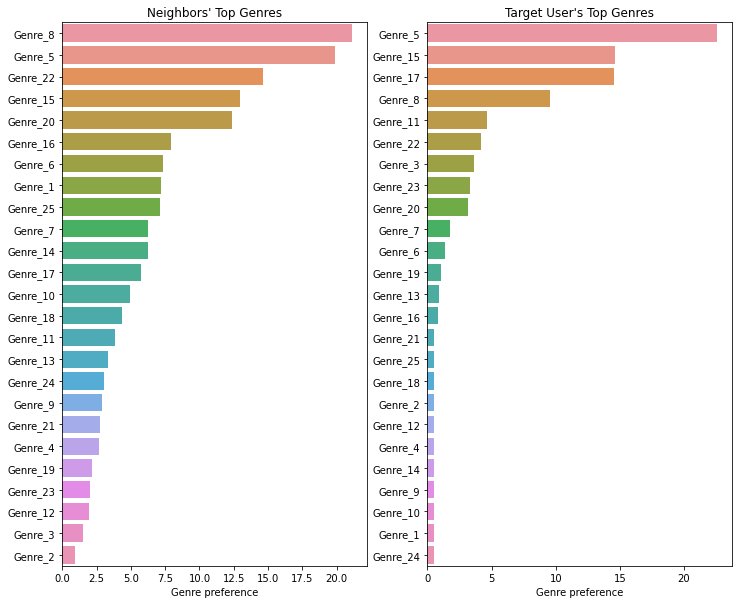

In [50]:
# Show top genres
plot_top_genres(neighbor_user_ratings, target_user_ratings)

In [51]:
# View most popular books among neighbors
neighbors_most_popular(neighbor_user_ratings, 15, write_to_excel=False)

,title,avg_rating,ratings_count,year,percent_similar_users_read,url
49,Secrets of a Side Bitch 3,4.58,1181.0,2014,1.6%,https://www.goodreads.com/book/show/20934376-s...
48,Secrets of a Side Bitch 2,4.54,1419.0,2013,1.6%,https://www.goodreads.com/book/show/18781068-s...
86,War's Unwomanly Face,4.52,1182.0,1988,1.6%,https://www.goodreads.com/book/show/4025275-wa...
34,In Order to Live: A North Korean Girl's Journe...,4.48,8076.0,2015,1.6%,https://www.goodreads.com/book/show/24611623-i...
6,Assata: An Autobiography,4.47,11057.0,1999,1.6%,https://www.goodreads.com/book/show/100322.Assata
89,"Who We Are (Bear, Otter, and the Kid, #2)",4.47,4184.0,2012,1.6%,https://www.goodreads.com/book/show/13579947-w...
52,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,2016,1.6%,https://www.goodreads.com/book/show/27220736-s...
5,Asking for It: The Alarming Rise of Rape Cultu...,4.39,1721.0,2015,1.6%,https://www.goodreads.com/book/show/17836520-a...
38,My Journey : Transforming Dreams into Actions,4.35,1743.0,2013,1.6%,https://www.goodreads.com/book/show/18371021-m...
84,"Traitor to the Throne (Rebel of the Sands, #2)",4.35,4825.0,2017,1.6%,https://www.goodreads.com/book/show/29739361-t...


In [52]:
# Highest rated books among similar readers
neighbors_top_rated(neighbor_user_ratings, 15, write_to_excel=False)

,title,avg_rating,ratings_count,year,url
49,Secrets of a Side Bitch 3,4.58,1181.0,2014,https://www.goodreads.com/book/show/20934376-s...
48,Secrets of a Side Bitch 2,4.54,1419.0,2013,https://www.goodreads.com/book/show/18781068-s...
86,War's Unwomanly Face,4.52,1182.0,1988,https://www.goodreads.com/book/show/4025275-wa...
34,In Order to Live: A North Korean Girl's Journe...,4.48,8076.0,2015,https://www.goodreads.com/book/show/24611623-i...
6,Assata: An Autobiography,4.47,11057.0,1999,https://www.goodreads.com/book/show/100322.Assata
89,"Who We Are (Bear, Otter, and the Kid, #2)",4.47,4184.0,2012,https://www.goodreads.com/book/show/13579947-w...
52,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,2016,https://www.goodreads.com/book/show/27220736-s...
5,Asking for It: The Alarming Rise of Rape Cultu...,4.39,1721.0,2015,https://www.goodreads.com/book/show/17836520-a...
38,My Journey : Transforming Dreams into Actions,4.35,1743.0,2013,https://www.goodreads.com/book/show/18371021-m...
84,"Traitor to the Throne (Rebel of the Sands, #2)",4.35,4825.0,2017,https://www.goodreads.com/book/show/29739361-t...


In [53]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target=target_user_ratings, 
    others=neighbor_user_ratings, 
    how="KNN", 
    whose_genres="target", 
    n_genres=5, 
    min_score=3.9, 
    min_ratings=400, 
    n_recs=15,
    write_to_excel=False
)

Genre 5: ['history', 'war', 'political', 'account', 'world', 'year', 'country', 'family', 'century', 'people']


,title,avg_rating,ratings_count,url
19,War's Unwomanly Face,4.52,1182.0,https://www.goodreads.com/book/show/4025275-wa...
8,In Order to Live: A North Korean Girl's Journe...,4.48,8076.0,https://www.goodreads.com/book/show/24611623-i...
0,Assata: An Autobiography,4.47,11057.0,https://www.goodreads.com/book/show/100322.Assata
20,Why I Am An Atheist: An Autobiographical Disco...,4.45,866.0,https://www.goodreads.com/book/show/1389596.Wh...
12,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,https://www.goodreads.com/book/show/27220736-s...
6,First They Killed My Father: A Daughter of Cam...,4.30,18580.0,https://www.goodreads.com/book/show/4373.First...
16,The Silk Roads: A New History of the World,4.25,3022.0,https://www.goodreads.com/book/show/25812847-t...
10,Pachinko,4.18,8161.0,https://www.goodreads.com/book/show/29983711-p...
18,Time Stops at Shamli and Other Stories,4.11,1091.0,https://www.goodreads.com/book/show/475218.Tim...
11,Scheisshaus Luck: Surviving the Unspeakable in...,4.09,1049.0,https://www.goodreads.com/book/show/3930572-sc...


_____

Genre 15: ['history', 'poem', 'essay', 'text', 'century', 'collection', 'world', 'writing', 'introduction', 'literature']


,title,avg_rating,ratings_count,url
11,The Invention of Nature: Alexander von Humbold...,4.29,4817.0,https://www.goodreads.com/book/show/23995249-t...
9,Srikanta,4.23,1004.0,https://www.goodreads.com/book/show/1417962.Sr...
2,Feminism is for Everybody: Passionate Politics,4.18,7740.0,https://www.goodreads.com/book/show/168484.Fem...
4,Guns,4.17,3687.0,https://www.goodreads.com/book/show/17284577-guns
12,The Purity Myth: How America's Obsession with ...,4.06,5741.0,https://www.goodreads.com/book/show/4914761-th...
0,Alice in Wonderland,4.03,346530.0,https://www.goodreads.com/book/show/13023.Alic...
13,Voyage of the Beagle,4.03,4417.0,https://www.goodreads.com/book/show/183645.Voy...
8,Octavia's Brood: Science Fiction Stories from ...,3.94,1088.0,https://www.goodreads.com/book/show/23129839-o...
3,"Go Down, Moses",3.93,7562.0,https://www.goodreads.com/book/show/17726.Go_D...
7,Nervous Conditions,3.92,6949.0,https://www.goodreads.com/book/show/158674.Ner...


_____

Genre 17: ['alien', 'planet', 'world', 'human', 'ship', 'space', 'war', 'crew', 'mission', 'race']


,title,avg_rating,ratings_count,url
0,"By Schism Rent Asunder (Safehold, #2)",4.10,5410.0,https://www.goodreads.com/book/show/2381756.By...
5,"The Light Fantastic (Discworld, #2; Rincewind #2)",3.94,76808.0,https://www.goodreads.com/book/show/34506.The_...
4,"The Clockwork Universe: Isaac Newton, the Roya...",3.91,3763.0,https://www.goodreads.com/book/show/9449985-th...


_____

Genre 8: ['guide', 'people', 'way', 'help', 'practical', 'world', 'experience', 'offer', 'question', 'business']


,title,avg_rating,ratings_count,url
12,The (7L) The Seven Levels of Communication: Go...,4.33,482.0,https://www.goodreads.com/book/show/9858250-th...
19,Totto-chan: The Little Girl at the Window,4.30,14456.0,https://www.goodreads.com/book/show/328802.Tot...
0,"""I Give You My Body . . ."": How I Write Sex Sc...",4.21,481.0,https://www.goodreads.com/book/show/30719827-i...
6,Mountains Beyond Mountains: The Quest of Dr. P...,4.21,53936.0,https://www.goodreads.com/book/show/10235.Moun...
1,Continuous Delivery: Reliable Software Release...,4.15,1748.0,https://www.goodreads.com/book/show/8686650-co...
17,Things No One Will Tell Fat Girls: A Handbook ...,4.06,1488.0,https://www.goodreads.com/book/show/24796533-t...
15,The Lean Startup: How Today's Entrepreneurs Us...,4.04,95622.0,https://www.goodreads.com/book/show/10127019-t...
16,The Rational Optimist: How Prosperity Evolves,3.98,4894.0,https://www.goodreads.com/book/show/7776209-th...
11,Thank You for Being Late: An Optimist's Guide ...,3.96,3010.0,https://www.goodreads.com/book/show/26114127-t...
4,Freakonomics: A Rogue Economist Explores the H...,3.94,529274.0,https://www.goodreads.com/book/show/1202.Freak...


_____

Genre 11: ['fiction', 'collection', 'world', 'literary', 'young', 'funny', 'short', 'comedy', 'horror', 'debut']


,title,avg_rating,ratings_count,url


_____



## Part 2 - User:Item Collaborative Filtering with Matrix Factorization

#### 2.1 - Matrix Factorization with SVD

In [54]:
# Find larger number of similar users than before to get broad pool of potentially relevant books
large_neighborhood_ratings, target_user_ratings = find_neighbors(2000, target, df_reviews, book_index, df_books)

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_39001/903381106.py:62: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_39001/903381106.py:63: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]


In [55]:
# Get unique users and books to slice df_reviews
neighbor_index = large_neighborhood_ratings["uid"].unique()
neighbor_index = np.append(neighbor_index, target)
neighbor_book_index = large_neighborhood_ratings["book_index"].unique()
neighbor_book_index = np.append(neighbor_book_index, target_user_ratings["book_index"].unique())

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, neighbor_book_index]
R = R[neighbor_index, :]

In [56]:
# Decompose user ratings matrix R
U, sigma, Vt = svds(R, k=5)
sigma = np.diag(sigma)

U = sparse.csr_matrix(U)
sigma = sparse.csr_matrix(sigma)
Vt = sparse.csr_matrix(Vt)

#### 2.2 - Generate Recommendations by Predicting Ratings

In [57]:
# Get predictions
all_user_predicted_ratings = U.dot(sigma) @ Vt
df_preds = pd.DataFrame(all_user_predicted_ratings.toarray(), columns=neighbor_book_index, index=neighbor_index)\
                .reset_index()

In [58]:
# Get target user's top predicted ratings
target_pred_books = df_preds[df_preds["index"] == target].columns[1:]
target_pred_ratings = df_preds[df_preds["index"] == target].values[0][1:]

# Put into df with relevant info from df_books
top_preds = pd.DataFrame({"book_index":target_pred_books, "predicted_rating":target_pred_ratings})\
                .sort_values(by="predicted_rating", ascending=False)\
                .merge(book_index.reset_index(), left_on="book_index", right_on="index")\
                .merge(
                    df_books[["book_id", "title", "avg_rating", "ratings_count", "year", "main_genre","url"]],
                    on="book_id"
                )\
                .drop(columns=["index", "book_id"])

# Filter out already read books
top_preds = top_preds[~top_preds["book_index"].isin(target_user_ratings["book_index"].unique())]
top_preds.drop(["book_index"], axis=1, inplace=True)

# Write to excel
path = wd + "/data/book_recs.xlsx"
if os.path.isfile(path):
    with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
        top_preds.query("avg_rating > 3.9").drop(columns=["predicted_rating", "main_genre"])\
            .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
else:
    with pd.ExcelWriter(path) as writer:
        top_preds.query("avg_rating > 3.9").drop(columns=["predicted_rating", "main_genre"])\
            .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
writer.close

top_preds.query("avg_rating > 3.9").head(20)    

,predicted_rating,title,avg_rating,ratings_count,year,main_genre,url
3,0.469163,I Am Malala: The Story of the Girl Who Stood U...,4.07,228884.0,2013,5.0,https://www.goodreads.com/book/show/17851885-i...
4,0.401024,Bad Feminist,3.91,43988.0,2014,16.0,https://www.goodreads.com/book/show/18813642-b...
7,0.330178,Wonder (Wonder #1),4.43,255461.0,2012,16.0,https://www.goodreads.com/book/show/11387515-w...
8,0.316087,Night (The Night Trilogy #1),4.30,708754.0,1958,20.0,https://www.goodreads.com/book/show/1617.Night
10,0.285437,Evicted: Poverty and Profit in the American City,4.47,18205.0,2016,20.0,https://www.goodreads.com/book/show/25852784-e...
11,0.265032,"A Clash of Kings (A Song of Ice and Fire, #2)",4.40,534960.0,2002,22.0,https://www.goodreads.com/book/show/10572.A_Cl...
12,0.263970,The New Jim Crow: Mass Incarceration in the Ag...,4.49,24694.0,2010,5.0,https://www.goodreads.com/book/show/6792458-th...
13,0.261014,"Wool Omnibus (Silo, #1)",4.24,83601.0,2012,2.0,https://www.goodreads.com/book/show/13453029-w...
15,0.226758,A Fighting Chance,4.17,8740.0,2014,5.0,https://www.goodreads.com/book/show/18779662-a...
17,0.218958,All the Ugly and Wonderful Things,4.10,35002.0,2016,23.0,https://www.goodreads.com/book/show/26114135-a...


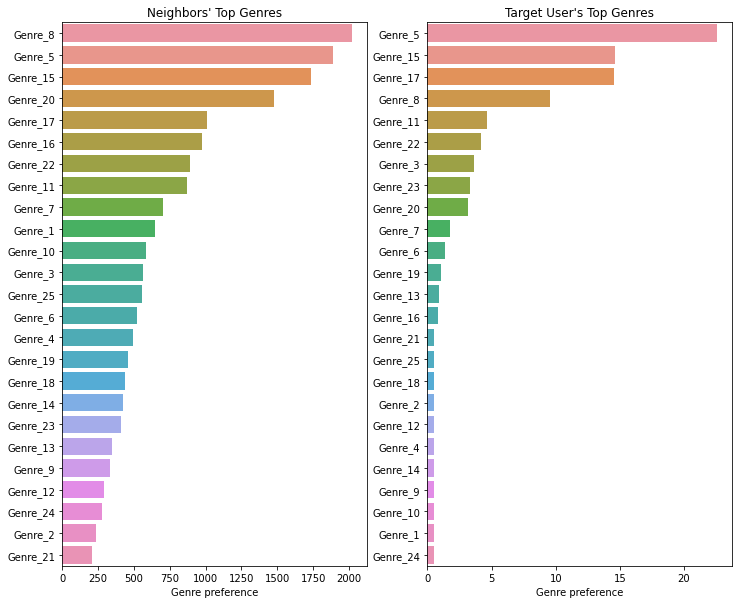

In [59]:
# Show top genres
plot_top_genres(large_neighborhood_ratings, target_user_ratings)

In [60]:
# View most popular books among neighbors
popular_recs = neighbors_most_popular(large_neighborhood_ratings, 50, write_to_excel=False)
popular_recs.head(15)

,title,avg_rating,ratings_count,year,percent_similar_users_read,url
1642,I Am Malala: The Story of the Girl Who Stood U...,4.07,228884.0,2013,2.8%,https://www.goodreads.com/book/show/17851885-i...
413,Bad Feminist,3.91,43988.0,2014,2.5%,https://www.goodreads.com/book/show/18813642-b...
4821,Wonder (Wonder #1),4.43,255461.0,2012,2.1%,https://www.goodreads.com/book/show/11387515-w...
50,"A Clash of Kings (A Song of Ice and Fire, #2)",4.40,534960.0,2002,2.0%,https://www.goodreads.com/book/show/10572.A_Cl...
2246,Night (The Night Trilogy #1),4.30,708754.0,1958,1.7%,https://www.goodreads.com/book/show/1617.Night
3605,The Gunslinger,3.98,346978.0,1982,1.6%,https://www.goodreads.com/book/show/43615.The_...
256,All the Ugly and Wonderful Things,4.10,35002.0,2016,1.4%,https://www.goodreads.com/book/show/26114135-a...
3577,The Golem and the Jinni (The Golem and the Jin...,4.10,61387.0,2013,1.4%,https://www.goodreads.com/book/show/15819028-t...
3052,Talking as Fast as I Can: From Gilmore Girls t...,4.03,35052.0,2016,1.4%,https://www.goodreads.com/book/show/30253864-t...
3969,"The Pillars of the Earth (Kingsbridge, #1)",4.29,471990.0,2002,1.3%,https://www.goodreads.com/book/show/5043.The_P...


In [61]:
# Highest rated books among similar readers
top_rated = neighbors_top_rated(large_neighborhood_ratings, 50, write_to_excel=False)
top_rated.head(15)

,title,avg_rating,ratings_count,year,url
4057,The Revenge of the Baby-Sat,4.71,11626.0,1991,https://www.goodreads.com/book/show/121792.The...
2692,Saga: Book One,4.70,4201.0,2014,https://www.goodreads.com/book/show/22078240-saga
4887,Yukon Ho!,4.70,8983.0,1989,https://www.goodreads.com/book/show/70491.Yuko...
3382,The Days Are Just Packed: A Calvin and Hobbes ...,4.69,19336.0,1993,https://www.goodreads.com/book/show/24818.The_...
4345,"The Way of Kings, Part 1 (The Stormlight Archi...",4.67,10191.0,2011,https://www.goodreads.com/book/show/9329354-th...
1647,I Dissent: Ruth Bader Ginsburg Makes Her Mark,4.67,1665.0,2016,https://www.goodreads.com/book/show/28210996-i...
3778,The Life and Times of Scrooge McDuck,4.67,2047.0,2005,https://www.goodreads.com/book/show/5309.The_L...
3649,The Holy Bible: English Standard Version,4.66,18613.0,2007,https://www.goodreads.com/book/show/5883777-th...
1909,Letter from the Birmingham Jail,4.64,2776.0,1994,https://www.goodreads.com/book/show/203899.Let...
3460,The Essential Calvin and Hobbes: A Calvin and ...,4.64,95116.0,1988,https://www.goodreads.com/book/show/43070.The_...


In [62]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target_user_ratings, 
    large_neighborhood_ratings, 
    preds=top_preds, 
    how="MF", 
    whose_genres="target", 
    n_genres=10, 
    min_score=4.15, 
    min_ratings=400, 
    n_recs=20,
    write_to_excel=True
)

Genre 5: ['history', 'war', 'political', 'account', 'world', 'year', 'country', 'family', 'century', 'people']


,title,avg_rating,ratings_count,url
12,The New Jim Crow: Mass Incarceration in the Ag...,4.49,24694.0,https://www.goodreads.com/book/show/6792458-th...
15,A Fighting Chance,4.17,8740.0,https://www.goodreads.com/book/show/18779662-a...
28,Persepolis: The Story of a Childhood (Persepol...,4.23,119470.0,https://www.goodreads.com/book/show/9516.Perse...
29,"March: Book One (March, #1)",4.34,21092.0,https://www.goodreads.com/book/show/17346698-m...
46,Digital Gold: Bitcoin and the Inside Story of ...,4.16,1674.0,https://www.goodreads.com/book/show/23546676-d...
59,The Girl with Seven Names: A North Korean Defe...,4.45,8293.0,https://www.goodreads.com/book/show/25362017-t...
78,Pachinko,4.18,8161.0,https://www.goodreads.com/book/show/29983711-p...
97,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,https://www.goodreads.com/book/show/27220736-s...
102,The Half Has Never Been Told: Slavery and the ...,4.43,1720.0,https://www.goodreads.com/book/show/14894629-t...
104,In Order to Live: A North Korean Girl's Journe...,4.48,8076.0,https://www.goodreads.com/book/show/24611623-i...


_____

Genre 15: ['history', 'poem', 'essay', 'text', 'century', 'collection', 'world', 'writing', 'introduction', 'literature']


,title,avg_rating,ratings_count,url
32,The Invention of Nature: Alexander von Humbold...,4.29,4817.0,https://www.goodreads.com/book/show/23995249-t...
85,Palestine,4.20,10082.0,https://www.goodreads.com/book/show/769712.Pal...
235,The Gene: An Intimate History,4.36,9874.0,https://www.goodreads.com/book/show/27276428-t...
263,Teaching My Mother How to Give Birth,4.38,7830.0,https://www.goodreads.com/book/show/13376363-t...
419,"The Autobiography of Martin Luther King, Jr.",4.32,11478.0,https://www.goodreads.com/book/show/42547.The_...
421,The Fire This Time: A New Generation Speaks ab...,4.35,2309.0,https://www.goodreads.com/book/show/28505023-t...
481,"The Big Picture: On the Origins of Life, Meani...",4.18,2208.0,https://www.goodreads.com/book/show/26150770-t...
461,The Essential Kierkegaard,4.16,1573.0,https://www.goodreads.com/book/show/24964.The_...
549,Fermat's Enigma: The Epic Quest to Solve the W...,4.22,16113.0,https://www.goodreads.com/book/show/38412.Ferm...
594,The World of Ice & Fire: The Untold History of...,4.26,12952.0,https://www.goodreads.com/book/show/17345242-t...


_____

Genre 17: ['alien', 'planet', 'world', 'human', 'ship', 'space', 'war', 'crew', 'mission', 'race']


,title,avg_rating,ratings_count,url
21,"Caliban's War (The Expanse, #2)",4.29,41459.0,https://www.goodreads.com/book/show/12591698-c...
131,"The Walking Dead, Compendium 1",4.43,58434.0,https://www.goodreads.com/book/show/6465707-th...
138,"I, Robot (Robot #0.1)",4.17,201196.0,https://www.goodreads.com/book/show/41804.I_Robot
149,Spillover: Animal Infections and the Next Huma...,4.27,2586.0,https://www.goodreads.com/book/show/13637215-s...
273,"Adulthood Rites (Xenogenesis, #2)",4.16,7081.0,https://www.goodreads.com/book/show/116249.Adu...
308,The Ultimate Hitchhiker's Guide to the Galaxy,4.38,225626.0,https://www.goodreads.com/book/show/13.The_Ult...
361,"First Shift: Legacy (Shift, #1)",4.21,15301.0,https://www.goodreads.com/book/show/13603717-f...
563,Maus I: A Survivor's Tale: My Father Bleeds Hi...,4.35,189288.0,https://www.goodreads.com/book/show/15196.Maus_I
770,Judas Unchained,4.30,21306.0,https://www.goodreads.com/book/show/45244.Juda...
781,"Wolf by Wolf (Wolf by Wolf, #1)",4.28,9710.0,https://www.goodreads.com/book/show/24807186-w...


_____

Genre 8: ['guide', 'people', 'way', 'help', 'practical', 'world', 'experience', 'offer', 'question', 'business']


,title,avg_rating,ratings_count,url
60,Mountains Beyond Mountains: The Quest of Dr. P...,4.21,53936.0,https://www.goodreads.com/book/show/10235.Moun...
69,NeuroTribes: The Legacy of Autism and the Futu...,4.29,3998.0,https://www.goodreads.com/book/show/22514020-n...
100,Word by Word: The Secret Life of Dictionaries,4.21,1422.0,https://www.goodreads.com/book/show/30781490-w...
107,"Saving Capitalism: For the Many, Not the Few",4.26,1818.0,https://www.goodreads.com/book/show/24338377-s...
109,"A Path Appears: Transforming Lives, Creating O...",4.21,1969.0,https://www.goodreads.com/book/show/20342518-a...
237,The Gifts of Imperfection: Let Go of Who You T...,4.17,49306.0,https://www.goodreads.com/book/show/7015403-th...
285,The Tale of the Dueling Neurosurgeons: The His...,4.19,5734.0,https://www.goodreads.com/book/show/18774002-t...
409,The Dictator's Handbook: Why Bad Behavior is A...,4.27,2497.0,https://www.goodreads.com/book/show/11612989-t...
416,"Creativity, Inc.: Overcoming the Unseen Forces...",4.24,27705.0,https://www.goodreads.com/book/show/18077903-c...
427,Algorithms to Live By: The Computer Science of...,4.16,4639.0,https://www.goodreads.com/book/show/25666050-a...


_____

Genre 11: ['fiction', 'collection', 'world', 'literary', 'young', 'funny', 'short', 'comedy', 'horror', 'debut']


,title,avg_rating,ratings_count,url
58,Asterios Polyp,4.19,20053.0,https://www.goodreads.com/book/show/4070095-as...
971,The Essential Dykes to Watch Out For,4.36,6979.0,https://www.goodreads.com/book/show/3189884-th...
1237,The Refrigerator Monologues,4.21,894.0,https://www.goodreads.com/book/show/32714267-t...
1403,Love's Executioner and Other Tales of Psychoth...,4.18,14376.0,https://www.goodreads.com/book/show/21027.Love...
1562,CivilWarLand in Bad Decline,4.22,1615.0,https://www.goodreads.com/book/show/331688.Civ...
1679,A Manual for Cleaning Women: Selected Stories,4.17,6863.0,https://www.goodreads.com/book/show/22929586-a...
1766,Cinema Panopticum,4.16,784.0,https://www.goodreads.com/book/show/634790.Cin...
2226,Peter and Alice,4.44,561.0,https://www.goodreads.com/book/show/17347724-p...
2240,A Supposedly Fun Thing I'll Never Do Again: E...,4.28,23746.0,https://www.goodreads.com/book/show/6748.A_Sup...
2861,What Was I Scared Of?,4.20,2493.0,https://www.goodreads.com/book/show/644346.Wha...


_____

Genre 22: ['world', 'power', 'enemy', 'war', 'battle', 'evil', 'magic', 'save', 'ancient', 'warrior']


,title,avg_rating,ratings_count,url
11,"A Clash of Kings (A Song of Ice and Fire, #2)",4.40,534960.0,https://www.goodreads.com/book/show/10572.A_Cl...
242,"The Last Unicorn (The Last Unicorn, #1)",4.18,77163.0,https://www.goodreads.com/book/show/29127.The_...
530,The False Prince (The Ascendance Trilogy #1),4.23,51292.0,https://www.goodreads.com/book/show/12432220-t...
674,"The Winter Crown (Eleanor of Aquitaine, #2)",4.21,1361.0,https://www.goodreads.com/book/show/19015834-t...
717,"Age of Myth (The Legends of the First Empire, #1)",4.27,9328.0,https://www.goodreads.com/book/show/26863057-a...
785,"Thrawn (Star Wars: Thrawn, #1)",4.30,5220.0,https://www.goodreads.com/book/show/31140332-t...
797,Rogue One: A Star Wars Story,4.17,3228.0,https://www.goodreads.com/book/show/30008713-r...
883,The Cartel,4.29,9961.0,https://www.goodreads.com/book/show/23602561-t...
1053,"Split the Party (Spells, Swords, & Stealth, #2)",4.25,2062.0,https://www.goodreads.com/book/show/25920141-s...
1079,Lost Boy: The True Story of Captain Hook,4.20,1420.0,https://www.goodreads.com/book/show/32828538-l...


_____

Genre 3: ['collection', 'comic', 'short', 'fan', 'feature', 'bestselling', 'adventure', 'available', 'classic', 'includes']


,title,avg_rating,ratings_count,url
750,"Harry Potter: The Prequel (Harry Potter, #0.5)",4.22,13267.0,https://www.goodreads.com/book/show/8933944-ha...
773,A Good Man is Hard to Find and Other Stories,4.24,26384.0,https://www.goodreads.com/book/show/48464.A_Go...
794,The Julian Chapter,4.32,11380.0,https://www.goodreads.com/book/show/20878809-t...
816,The Kite Runner: Graphic Novel,4.25,6466.0,https://www.goodreads.com/book/show/11296523-t...
896,2016 on Goodreads,4.25,1167.0,https://www.goodreads.com/book/show/33232571-2...
987,Y: The Last Man - The Deluxe Edition Book One,4.36,10549.0,https://www.goodreads.com/book/show/3710603-y
996,The Dark Tower,4.27,96576.0,https://www.goodreads.com/book/show/5091.The_D...
1005,"Batman, Volume 3: Death of the Family",4.33,8461.0,https://www.goodreads.com/book/show/17671913-b...
1090,"Ms. Marvel, #1: Meta Morphosis",4.32,4702.0,https://www.goodreads.com/book/show/18757876-m...
1225,"The Hedge Knight (The Tales of Dunk and Egg, #1)",4.23,14640.0,https://www.goodreads.com/book/show/11970747-t...


_____

Genre 23: ['agent', 'team', 'mission', 'job', 'dead', 'terrorist', 'zombie', 'government', 'secret', 'drug']


,title,avg_rating,ratings_count,url
486,The Plot to Hack America: How Putin’s Cyberspi...,4.17,444.0,https://www.goodreads.com/book/show/32202585-t...
1333,"Much Obliged, Jeeves",4.24,472.0,https://www.goodreads.com/book/show/16394.Much...
1732,The Legend of Korra: Turf Wars Part One (Turf ...,4.35,1946.0,https://www.goodreads.com/book/show/33161035-t...
2047,Daredevil: Born Again,4.31,597.0,https://www.goodreads.com/book/show/6929380-da...
2194,Never Split the Difference: Negotiating As If ...,4.49,3314.0,https://www.goodreads.com/book/show/26156469-n...
2371,"Dust & Decay (Rot & Ruin, #2)",4.28,13867.0,https://www.goodreads.com/book/show/9917998-du...
2384,"The First Hostage (J. B. Collins, #2)",4.43,1619.0,https://www.goodreads.com/book/show/26043842-t...
3681,"Lucifer, Book One (Lucifer, #1)",4.24,1708.0,https://www.goodreads.com/book/show/17137616-l...
3822,The Smallest Dragonboy,4.27,4232.0,https://www.goodreads.com/book/show/2386345.Th...
4541,American Pain: How a Young Felon and His Ring ...,4.23,692.0,https://www.goodreads.com/book/show/25992990-a...


_____

Genre 20: ['family', 'year', 'child', 'young', 'home', 'past', 'world', 'loss', 'secret', 'friend']


,title,avg_rating,ratings_count,url
8,Night (The Night Trilogy #1),4.30,708754.0,https://www.goodreads.com/book/show/1617.Night
10,Evicted: Poverty and Profit in the American City,4.47,18205.0,https://www.goodreads.com/book/show/25852784-e...
54,Persepolis 2: The Story of a Return (Persepoli...,4.23,46987.0,https://www.goodreads.com/book/show/9517.Perse...
93,Maus II: A Survivor's Tale: And Here My Troubl...,4.40,93669.0,https://www.goodreads.com/book/show/15197.Maus_II
127,The Story of a New Name (The Neapolitan Novels...,4.36,36545.0,https://www.goodreads.com/book/show/17465515-t...
128,Daytripper,4.31,18265.0,https://www.goodreads.com/book/show/8477057-da...
571,You Don't Have to Say You Love Me,4.36,4478.0,https://www.goodreads.com/book/show/31420708-y...
658,"Instrumental: A Memoir of Madness, Medication ...",4.26,1796.0,https://www.goodreads.com/book/show/21896497-i...
739,The Heart of a Woman,4.19,16156.0,https://www.goodreads.com/book/show/5160.The_H...
783,Swami and Friends,4.21,8253.0,https://www.goodreads.com/book/show/732482.Swa...


_____

Genre 7: ['fairy', 'magic', 'adventure', 'world', 'magical', 'die', 'fantasy', 'journey', 'young', 'land']


,title,avg_rating,ratings_count,url
26,"The Pillars of the Earth (Kingsbridge, #1)",4.29,471990.0,https://www.goodreads.com/book/show/5043.The_P...
438,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,4.59,92172.0,https://www.goodreads.com/book/show/30.J_R_R_T...
577,"The Lion, the Witch, and the Wardrobe (Chronic...",4.19,1575387.0,https://www.goodreads.com/book/show/100915.The...
646,"Niccolò Rising (The House of Niccolò, #1)",4.27,2897.0,https://www.goodreads.com/book/show/112078.Nic...
736,Bridge of Birds (The Chronicles of Master Li a...,4.30,8063.0,https://www.goodreads.com/book/show/15177.Brid...
815,The Forest Unseen: A Year’s Watch in Nature,4.19,1576.0,https://www.goodreads.com/book/show/11797368-t...
836,"The Spring of the Ram (The House of Niccolo, #2)",4.39,1949.0,https://www.goodreads.com/book/show/112075.The...
914,Jaya: An Illustrated Retelling of the Mahabharata,4.20,9857.0,https://www.goodreads.com/book/show/9864913-jaya
970,Echo,4.36,16126.0,https://www.goodreads.com/book/show/22749539-echo
995,Interstellar Cinderella,4.22,2024.0,https://www.goodreads.com/book/show/22875394-i...


_____



### 2.3 Matrix Factorization with Gradient Descent

In [63]:
R = R.toarray()

In [86]:
# Function to train embedding matrices using alternating least squares (ALS) and make predictions 
def matrix_factorization(R, k=5, steps=4000, lr=0.0002, beta=0.02, verbose=0):
    """
    Uses gradient descent to train matrix factorization algorithm. Useful explanation
    of the math here: 
    http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/#source-code

    Args:
        R: Utility matrix of user item ratings         
        k: Number of latent features
        steps: Number of epochs to run training
        lr: Learning rate
        beta: Regularization strength
        verbose: Prints updates if 1

    Returns:
        Predictions, User Embeddings, Item Embdeddings
    """

    # Initialize random values for user (P) and book (Q) embedding matrices
    K = k
    P = np.random.rand(R.shape[0],k)
    Q = np.random.rand(R.shape[1],k).T

    for step in range(steps): # For each steps
        r_0 = np.where(R > 0) # Find indices where rating > 0
        e = 0 # Initialize error for step to 0
        i = r_0[0]
        j = r_0[1]
        resid = R[i,j] - (P @ Q)[i,j] # residual is value - r_hat       
        for k in range(K): # for each component (latent feature)                
            P[i,k] = P[i,k] + lr * (2 * resid * Q[k,j] - beta * P[i,k]) # Update P by step in gradient                             
            Q[k,j] = Q[k,j] + lr * (2 * resid * P[i,k] - beta * Q[k,j]) # Update Q by step in gradient            

        # Calculate error every 1k steps
        e = 0 # Initialize counter for error            
        if (step + 1) % 1000 == 0: # Only do every 1k steps
            e = e + np.sum(pow(resid, 2)) # Add to error
            for k in range(K): # for each component (latent feature)                             
                e = e + (beta/2) * np.sum(pow(P[i,k],2) + pow(Q[k,j],2)) # Update error with regularized term

            # View progress
            if verbose == 1:
                print(f"Step: {step + 1}, error: {e}") # Print update                           

        # # Break loop if error is very small
        # if (step > 1500) & (e < 0.001):
        #     break
    
    # Get predictions
    preds = np.dot(P, Q)

    return preds, P, Q.T

In [87]:
# Train model and get predictions
preds, user_embeddings, item_embeddings = matrix_factorization(R, k=30, lr=0.0001, steps=5000, verbose=1)

KeyboardInterrupt: 

In [ ]:
# Make dataframe from predictions and indices
df_preds = pd.DataFrame(preds, columns=neighbor_book_index, index=neighbor_index)\
                .reset_index()

# Get target user's top predicted ratings
target_pred_books = df_preds[df_preds["index"] == target].columns[1:]
target_pred_ratings = df_preds[df_preds["index"] == target].values[0][1:]

# Put into df with relevant info from df_books
top_preds = pd.DataFrame({"book_index":target_pred_books, "predicted_rating":target_pred_ratings})\
                .sort_values(by="predicted_rating", ascending=False)\
                .merge(book_index.reset_index(), left_on="book_index", right_on="index")\
                .merge(
                    df_books[["book_id", "title", "avg_rating", "ratings_count", "year", "main_genre","url"]],
                    on="book_id"
                )\
                .drop(columns=["index"])

# View preds on actually read books
target_books_preds = top_preds[top_preds["book_index"].isin(target_user_ratings["book_index"].unique())]\
                        .drop(["book_index"], axis=1)
target_books_preds = pd.merge(target_books_preds, target_user_ratings[["book_id", "user_rating"]], on="book_id")
target_books_preds["diff"] = target_books_preds["predicted_rating"] - target_books_preds["user_rating"]
print("Predictions on Actually Read Books")
display(target_books_preds[["title", "predicted_rating", "user_rating", "diff"]])

# Filter out already read books to get top preds
print("___________\n")
print("Predictions on Unread Books")
top_preds = top_preds[~top_preds["book_index"].isin(target_user_ratings["book_index"].unique())]
display(top_preds[["title","avg_rating","predicted_rating","ratings_count","year","url"]]\
        .query("avg_rating > 3.9").head(20)
    )

Predictions on Actually Read Books


,title,predicted_rating,user_rating,diff
0,Black Flags: The Rise of ISIS,4.671872,5.0,-0.328128
1,The Three-Body Problem (Remembrance of Earth’s...,4.584880,5.0,-0.415120
2,"The Alchemy of Air: A Jewish Genius, a Doomed ...",4.529917,5.0,-0.470083
3,"The Stone Sky (The Broken Earth, #3)",4.501182,5.0,-0.498818
4,The Wind-Up Bird Chronicle,4.481811,5.0,-0.518189
...,...,...,...,...
90,"Akira, Vol. 1",2.137862,2.0,0.137862
91,The Doors of Perception,2.116260,2.0,0.116260
92,Fear and Loathing in Las Vegas,1.975161,2.0,-0.024839
93,Hillbilly Elegy: A Memoir of a Family and Cult...,1.619771,1.0,0.619771


___________

Predictions on Unread Books


,title,avg_rating,predicted_rating,ratings_count,year,url
1,Cowboys Are My Weakness,4.03,5.374017,3976.0,2005,https://www.goodreads.com/book/show/126741.Cow...
2,Keto-Adapted,4.19,5.203318,306.0,2013,https://www.goodreads.com/book/show/19091151-k...
3,Hold Your Own,4.22,5.106108,1354.0,2014,https://www.goodreads.com/book/show/23780641-h...
4,The Willows,4.11,5.030141,4018.0,2002,https://www.goodreads.com/book/show/1335601.Th...
5,Imagine a Night,4.38,4.989038,506.0,2003,https://www.goodreads.com/book/show/549865.Ima...
6,"Attack on Titan, Volume 15",4.40,4.956747,1081.0,2015,https://www.goodreads.com/book/show/22716573-a...
9,The Tibetan Book of Living and Dying,4.21,4.898512,17807.0,2012,https://www.goodreads.com/book/show/206731.The...
10,Imagine a Place,4.34,4.886638,370.0,2008,https://www.goodreads.com/book/show/3002251-im...
11,The Summer that Melted Everything,3.96,4.859965,2758.0,2016,https://www.goodreads.com/book/show/26114523-t...
16,How We Got to Now: Six Innovations That Made t...,4.04,4.820709,6729.0,2014,https://www.goodreads.com/book/show/20893477-h...


In [ ]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target_user_ratings, 
    large_neighborhood_ratings, 
    preds=top_preds, 
    how="MF", 
    whose_genres="target", 
    n_genres=10, 
    min_score=4.15, 
    min_ratings=400, 
    n_recs=20,
    write_to_excel=True
)

Genre 5: ['history', 'war', 'political', 'account', 'world', 'year', 'country', 'family', 'century', 'people']


,title,avg_rating,ratings_count,url
50,Big Girls Don't Cry: The Election that Changed...,4.16,1175.0,https://www.goodreads.com/book/show/8392798-bi...
96,Half the Sky: Turning Oppression into Opportun...,4.31,1484.0,https://www.goodreads.com/book/show/7240582-ha...
100,Unequal Protection: The Rise of Corporate Domi...,4.22,413.0,https://www.goodreads.com/book/show/433932.Une...
195,Janesville: An American Story,4.26,661.0,https://www.goodreads.com/book/show/33665908-j...
246,My Dearest Friend: Letters of Abigail and John...,4.17,1512.0,https://www.goodreads.com/book/show/436582.My_...
287,Auschwitz and After,4.35,758.0,https://www.goodreads.com/book/show/339757.Aus...
299,"Under a Cruel Star: A Life in Prague, 1941-1968",4.23,1219.0,https://www.goodreads.com/book/show/196742.Und...
317,"The Power of One (The Power of One, #1)",4.34,58836.0,https://www.goodreads.com/book/show/122.The_Po...
322,Diplomacy,4.18,4584.0,https://www.goodreads.com/book/show/781183.Dip...
356,Bobby Kennedy: The Making of a Liberal Icon,4.37,748.0,https://www.goodreads.com/book/show/28495892-b...


_____

Genre 15: ['history', 'poem', 'essay', 'text', 'century', 'collection', 'world', 'writing', 'introduction', 'literature']


,title,avg_rating,ratings_count,url
3,Hold Your Own,4.22,1354.0,https://www.goodreads.com/book/show/23780641-h...
20,Her Smoke Rose Up Forever,4.22,2539.0,https://www.goodreads.com/book/show/27059.Her_...
84,Primeval and Other Times,4.19,1040.0,https://www.goodreads.com/book/show/6617921-pr...
88,Desert Solitaire,4.22,28380.0,https://www.goodreads.com/book/show/214614.Des...
144,I Write What I Like: Selected Writings,4.33,1516.0,https://www.goodreads.com/book/show/61124.I_Wr...
148,Memoirs of Hadrian,4.25,8321.0,https://www.goodreads.com/book/show/12172.Memo...
171,"Sifting Through the Madness for the Word, the ...",4.24,1908.0,https://www.goodreads.com/book/show/50469.Sift...
186,Things That Are,4.21,514.0,https://www.goodreads.com/book/show/13239399-t...
232,Well-Read Women: Portraits of Fiction's Most B...,4.30,861.0,https://www.goodreads.com/book/show/17557474-w...
253,Alchemy of Race and Rights,4.27,570.0,https://www.goodreads.com/book/show/221700.Alc...


_____

Genre 17: ['alien', 'planet', 'world', 'human', 'ship', 'space', 'war', 'crew', 'mission', 'race']


,title,avg_rating,ratings_count,url
30,"Ghosts of the Tristan Basin (Powder Mage, #0.8)",4.34,584.0,https://www.goodreads.com/book/show/28825810-g...
376,"Nil Unlocked (Nil, #2)",4.23,886.0,https://www.goodreads.com/book/show/22718810-n...
449,Pandora's Star,4.24,28964.0,https://www.goodreads.com/book/show/45252.Pand...
523,The Veldt,4.21,3958.0,https://www.goodreads.com/book/show/120555.The...
532,"The Walking Dead, Compendium 3",4.62,4378.0,https://www.goodreads.com/book/show/25536846-t...
714,"Mouse Guard: Winter 1152 (Mouse Guard, #2)",4.18,6035.0,https://www.goodreads.com/book/show/3124317-mo...
798,The Peregrine,4.18,1040.0,https://www.goodreads.com/book/show/1071726.Th...
867,"Grant Moves South, 1861-1863",4.38,468.0,https://www.goodreads.com/book/show/802887.Gra...
872,The Hyperion Omnibus: Hyperion / The Fall of H...,4.41,2254.0,https://www.goodreads.com/book/show/3943.The_H...
897,This Thing of Darkness,4.48,1134.0,https://www.goodreads.com/book/show/142050.Thi...


_____

Genre 8: ['guide', 'people', 'way', 'help', 'practical', 'world', 'experience', 'offer', 'question', 'business']


,title,avg_rating,ratings_count,url
9,The Tibetan Book of Living and Dying,4.21,17807.0,https://www.goodreads.com/book/show/206731.The...
19,"No Death, No Fear",4.30,2017.0,https://www.goodreads.com/book/show/187636.No_...
24,Harry Potter Schoolbooks Box Set: Two Classic ...,4.40,10914.0,https://www.goodreads.com/book/show/2002.Harry...
85,Maximum Achievement: Strategies and Skills tha...,4.27,2572.0,https://www.goodreads.com/book/show/115613.Max...
97,Every Good Endeavor: Connecting Your Work to G...,4.27,3735.0,https://www.goodreads.com/book/show/13589149-e...
104,Models: Attract Women Through Honesty,4.44,3362.0,https://www.goodreads.com/book/show/12633800-m...
124,"The Divine Matrix: Bridging Time, Space, Mirac...",4.23,3370.0,https://www.goodreads.com/book/show/90560.The_...
230,Radical: Taking Back Your Faith from the Ameri...,4.18,37134.0,https://www.goodreads.com/book/show/7497897-ra...
240,"You Are Special (Wemmicksville, #1)",4.45,41780.0,https://www.goodreads.com/book/show/56728.You_...
252,See You at the Top,4.25,9153.0,https://www.goodreads.com/book/show/161415.See...


_____

Genre 11: ['fiction', 'collection', 'world', 'literary', 'young', 'funny', 'short', 'comedy', 'horror', 'debut']


,title,avg_rating,ratings_count,url
486,Hyperbole and a Half,4.17,3692.0,https://www.goodreads.com/book/show/17906245-h...
620,Asterios Polyp,4.19,20053.0,https://www.goodreads.com/book/show/4070095-as...
753,"Will You Please Be Quiet, Please?",4.29,808.0,https://www.goodreads.com/book/show/759826.Wil...
876,The Fortune of War,4.38,8195.0,https://www.goodreads.com/book/show/77426.The_...
1008,Love's Executioner and Other Tales of Psychoth...,4.18,14376.0,https://www.goodreads.com/book/show/21027.Love...
1381,Incidences,4.32,658.0,https://www.goodreads.com/book/show/685172.Inc...
1563,What Was I Scared Of?,4.20,2493.0,https://www.goodreads.com/book/show/644346.Wha...
1656,CivilWarLand in Bad Decline,4.22,1615.0,https://www.goodreads.com/book/show/331688.Civ...
1862,What Matters Most is How Well You Walk Through...,4.30,4351.0,https://www.goodreads.com/book/show/632901.Wha...
1934,The Picnic and Suchlike Pandemonium,4.21,569.0,https://www.goodreads.com/book/show/111791.The...


_____

Genre 22: ['world', 'power', 'enemy', 'war', 'battle', 'evil', 'magic', 'save', 'ancient', 'warrior']


,title,avg_rating,ratings_count,url
37,"Darksong (The Legendsong, #2)",4.32,1210.0,https://www.goodreads.com/book/show/1961402.Da...
70,"Dawn of Wonder (The Wakening, #1)",4.35,13351.0,https://www.goodreads.com/book/show/25451852-d...
90,The Winter King: A Novel of Arthur (The Warlor...,4.27,504.0,https://www.goodreads.com/book/show/11365380-t...
190,"Rurouni Kenshin, Volume 09",4.39,1957.0,https://www.goodreads.com/book/show/294980.Rur...
297,"Avatar: The Last Airbender: The Search, Part 2...",4.35,4658.0,https://www.goodreads.com/book/show/17445144-a...
406,"Ice Massacre (Mermaids of Eriana Kwai, #1)",4.23,663.0,https://www.goodreads.com/book/show/22718724-i...
428,Time and Chance (Henry II & Eleanor of Aquitai...,4.28,6106.0,https://www.goodreads.com/book/show/234560.Tim...
439,"Red Sister (Book of the Ancestor, #1)",4.32,5784.0,https://www.goodreads.com/book/show/25895524-r...
453,When Christ and His Saints Slept (Henry II an...,4.27,10892.0,https://www.goodreads.com/book/show/43841.When...
531,"The Crimson Campaign (Powder Mage, #2)",4.35,15125.0,https://www.goodreads.com/book/show/17608111-t...


_____

Genre 3: ['collection', 'comic', 'short', 'fan', 'feature', 'bestselling', 'adventure', 'available', 'classic', 'includes']


,title,avg_rating,ratings_count,url
257,The Collected Stories of Philip K. Dick 5: The...,4.25,1146.0,https://www.goodreads.com/book/show/22585.The_...
280,Star Wars: A Pop-Up Guide to the Galaxy,4.46,558.0,https://www.goodreads.com/book/show/758707.Sta...
291,The Dark Tower: The Gunslinger Born,4.18,62544.0,https://www.goodreads.com/book/show/342445.The...
335,The Stinky Cheese Man and Other Fairly Stupid ...,4.20,79914.0,https://www.goodreads.com/book/show/407429.The...
519,The Lands of Ice and Fire: Maps from King's La...,4.43,1095.0,https://www.goodreads.com/book/show/15721980-t...
524,The Collected Stories,4.25,3820.0,https://www.goodreads.com/book/show/6670287-th...
625,"Preacher, Volume 7: Salvation",4.30,14140.0,https://www.goodreads.com/book/show/102954.Pre...
1326,Saga: Book One,4.70,4201.0,https://www.goodreads.com/book/show/22078240-saga
1346,"The Walking Dead, Compendium 2",4.53,13782.0,https://www.goodreads.com/book/show/14744381-t...
1397,"The Complete Stories, Vol 1",4.35,4576.0,https://www.goodreads.com/book/show/30010.The_...


_____

Genre 23: ['agent', 'team', 'mission', 'job', 'dead', 'terrorist', 'zombie', 'government', 'secret', 'drug']


,title,avg_rating,ratings_count,url
6,"Attack on Titan, Volume 15",4.40,1081.0,https://www.goodreads.com/book/show/22716573-a...
281,The Smallest Dragonboy,4.27,4232.0,https://www.goodreads.com/book/show/2386345.Th...
384,The Legend of Korra: Turf Wars Part One (Turf ...,4.35,1946.0,https://www.goodreads.com/book/show/33161035-t...
2300,"Rurouni Kenshin, Volume 26",4.38,1481.0,https://www.goodreads.com/book/show/294971.Rur...
2546,Daredevil: Born Again,4.31,597.0,https://www.goodreads.com/book/show/6929380-da...
2718,The Match: The Day the Game of Golf Changed Fo...,4.32,1532.0,https://www.goodreads.com/book/show/571428.The...
3009,The Private Eye #1,4.24,512.0,https://www.goodreads.com/book/show/17662660-t...
3249,The Girl Who Played with Fire (Millennium #2),4.22,7361.0,https://www.goodreads.com/book/show/6087991-th...
3437,American Pain: How a Young Felon and His Ring ...,4.23,692.0,https://www.goodreads.com/book/show/25992990-a...
3576,"Much Obliged, Jeeves",4.24,472.0,https://www.goodreads.com/book/show/16394.Much...


_____

Genre 20: ['family', 'year', 'child', 'young', 'home', 'past', 'world', 'loss', 'secret', 'friend']


,title,avg_rating,ratings_count,url
18,The Seven Good Years,4.16,2373.0,https://www.goodreads.com/book/show/23399025-t...
314,A Tale of Love and Darkness,4.20,3965.0,https://www.goodreads.com/book/show/27574.A_Ta...
340,The Outside Circle: A Graphic Novel,4.23,875.0,https://www.goodreads.com/book/show/23130299-t...
360,Dear Evan Hansen,4.70,563.0,https://www.goodreads.com/book/show/34381137-d...
411,All But My Life: A Memoir,4.28,14073.0,https://www.goodreads.com/book/show/163363.All...
615,I Loved You More,4.17,456.0,https://www.goodreads.com/book/show/18226784-i...
637,"Good Night, Mr. Tom",4.28,25271.0,https://www.goodreads.com/book/show/161099.Goo...
885,Lighter Than My Shadow,4.40,1061.0,https://www.goodreads.com/book/show/17456953-l...
957,"Far from the Tree: Parents, Children, and the ...",4.27,12131.0,https://www.goodreads.com/book/show/13547504-f...
961,Positive: A Memoir,4.28,2183.0,https://www.goodreads.com/book/show/20306819-p...


_____

Genre 7: ['fairy', 'magic', 'adventure', 'world', 'magical', 'die', 'fantasy', 'journey', 'young', 'land']


,title,avg_rating,ratings_count,url
73,"The Pillars of the Earth (Kingsbridge, #1)",4.29,471990.0,https://www.goodreads.com/book/show/5043.The_P...
220,"The Physician (Cole Family Trilogy, #1)",4.35,19716.0,https://www.goodreads.com/book/show/4692.The_P...
832,"The Aviators: Eddie Rickenbacker, Jimmy Doolit...",4.31,1579.0,https://www.goodreads.com/book/show/17345262-t...
1041,We Found a Hat,4.21,1003.0,https://www.goodreads.com/book/show/28586748-w...
1113,Uncle Dynamite,4.28,518.0,https://www.goodreads.com/book/show/16241184-u...
1260,Interstellar Cinderella,4.22,2024.0,https://www.goodreads.com/book/show/22875394-i...
1519,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,4.59,92172.0,https://www.goodreads.com/book/show/30.J_R_R_T...
1569,In the Cities of Coin and Spice (The Orphan's ...,4.39,2060.0,https://www.goodreads.com/book/show/547448.In_...
1606,Grounded: The Adventures of Rapunzel (Tyme #1),4.16,1438.0,https://www.goodreads.com/book/show/23399287-g...
1671,Bridge of Birds (The Chronicles of Master Li a...,4.30,8063.0,https://www.goodreads.com/book/show/15177.Brid...


_____

